# DID analysis about the number of submissions

## Install and import packages

In [6]:
# 必要なパッケージをインストール
%pip install pandas statsmodels matplotlib seaborn

# パッケージの読み込み
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


## Load data

In [2]:
# Load the two CSV files
file_treatment = "./submissions_Palestine_Israel_IsraelPalestine_20241023_164200.csv"
file_control = "./submissions_ps4homebrew_Exercise_voyageons_20241023_171400.csv"

# Reading the treatment and control group data
df_treatment = pd.read_csv(file_treatment)
df_control = pd.read_csv(file_control)

# Display basic information about the datasets to understand their structure
df_treatment.info(), df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2712 non-null   object
 1   created_utc  2712 non-null   object
 2   score        2712 non-null   int64 
 3   url          2712 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1734 non-null   object
 1   created_utc  1734 non-null   object
 2   score        1734 non-null   int64 
 3   url          1734 non-null   object
dtypes: int64(1), object(3)
memory usage: 54.3+ KB


(None, None)

## Grouping data into treatment or control

In [4]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
df_treatment['created_utc'] = pd.to_datetime(df_treatment['created_utc'], utc=True)
df_control['created_utc'] = pd.to_datetime(df_control['created_utc'], utc=True)

# Add group identifier: 1 for treatment, 0 for control
df_treatment['group'] = 1
df_control['group'] = 0

# Merge both datasets for analysis
df_combined = pd.concat([df_treatment, df_control], ignore_index=True)

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
df_combined['post_treatment'] = (df_combined['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
df_combined['date'] = df_combined['created_utc'].dt.date
daily_counts = df_combined.groupby(['date', 'group', 'post_treatment']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_counts.head()

,date,group,post_treatment,submission_count
0,2024-07-25,0,0,6
1,2024-07-25,1,0,9
2,2024-07-26,0,0,7
3,2024-07-26,1,0,6
4,2024-07-27,0,0,7


## Create model and output summary

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create the interaction term for DID
daily_counts['interaction'] = daily_counts['group'] * daily_counts['post_treatment']

# Define the DID regression model: submission_count ~ group + post_treatment + interaction
did_model = ols('submission_count ~ group + post_treatment + interaction', data=daily_counts).fit()

# Output the summary of the DID regression results
did_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       submission_count   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     190.6
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           2.43e-55
Time:                        18:34:31   Log-Likelihood:                -731.53
No. Observations:                 182   AIC:                             1471.
Df Residuals:                     178   BIC:                             1484.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         18.3676      1.652     11.121      0.000      15.108      21.627
group             -7.9118      2.336     -3.387      0.001     -12.521      -3.302
post_treatment     2.7193      3.285      0.828      0.409      -3.764       9.203
interaction       73.8248      4.646     15.889      0.000      64.656      82.994
==============================================================================
Omnibus:                      142.527   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2628.751
Skew:                           2.665   Prob(JB):                         0.00
Kurtosis:                      20.839   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualization

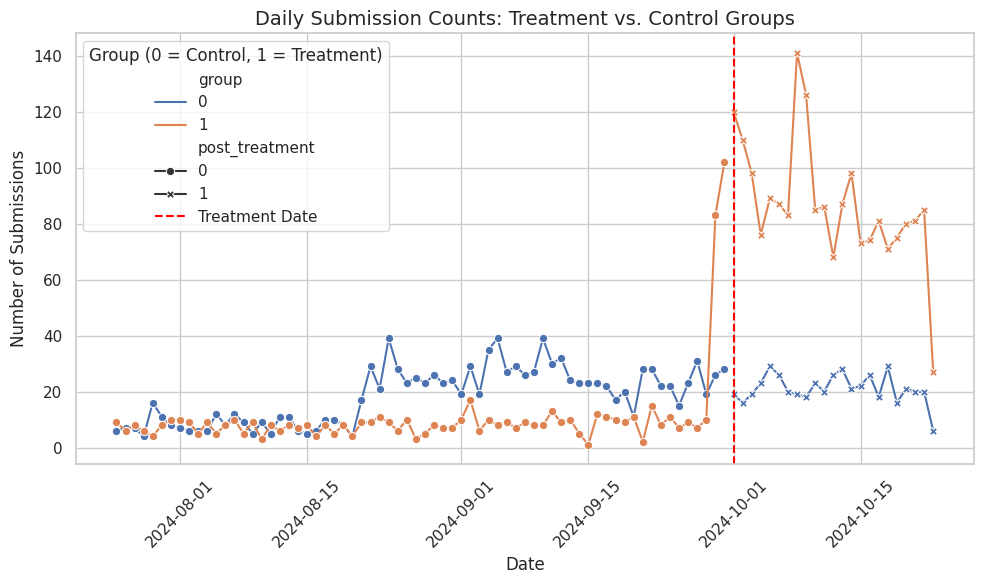

In [7]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=daily_counts, x='date', y='submission_count', hue='group', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
